In [9]:
import mosaik
import mosaik.util
from pv_configurations import generate_configurations, Scenarios
import simbench
import pandapower.plotting as plot
import matplotlib.pyplot as plt
import pandapower as pp
import pandas as pd
import matplotlib
import nest_asyncio
import numpy as np
import re
import pandapower.networks as pn
import os
import sys

# Add local-mosaik-pandapower-2.src.mosaik_components to Python path
module_path = os.path.abspath(os.path.join(os.getcwd(), 'local-mosaik-pandapower-2', 'src'))

if module_path not in sys.path:
    sys.path.insert(0, module_path)


def getElementbyName(grid, name):
    """
    Get the element by name from the DataFrame.
    """
    for element in grid.children:
        if element.extra_info['name'] == name:
            return element
    return None    
#matplotlib.use("Qt5Agg")  # Use "Qt5Agg" if you have PyQt5 installed

# Simulator backends
SIM_CONFIG = {
    'ChargerSim': {        
        'python': 'mosaik_csv:CSV'
    },  
    # 'PVSim': {
    #     'python': 'mosaik_components.pv.photovoltaic_simulator:PVSimulator'
    # },
    'CSV_writer': {
        'python': 'mosaik_csv_writer:CSVWriter',
    },
    "Pandapower": {
        'python': 'mosaik_components.pandapower:Simulator'
    }
}

START = "2024-12-01 00:15:00"
END = 3600 * 3
STEP_SIZE = 60 * 15
CHARGER_DATA = "./dados-carregamento-normal.csv"

#this is needed to use mosaik on ipynbs
nest_asyncio.apply()

world = mosaik.World(SIM_CONFIG)


        ____                              _ _
       /    \                            (_) |
  ____/      \  _ __ ___   ___  ___  __ _ _| | __
 /    \      / | '_ ` _ \ / _ \/ __|/ _` | | |/ /
/      \____/  | | | | | | (_) \__ \ (_| | |   <
\      /    \  |_| |_| |_|\___/|___/\__,_|_|_|\_\
 \____/      \____
 /    \      /    \     mosaik: 3.5.0
/      \____/      \       API: 3.0.13
\      /    \      /    Python: 3.13.3
 \____/      \____/         OS: Linux-6.5.0-1025-oem-x86_64-with-glibc2.36
      \      /            Docs: https://mosaik.readthedocs.io/en/3.5.0/
       \____/     Get in touch: https://github.com/orgs/OFFIS-mosaik/discussions



Connect Simulators Together

In [10]:

#Configure charger component
#charger_sim = world.start("ChargerSim", sim_start=START, datafile=CHARGER_DATA)
#charger_model = charger_sim.Charger1.create(1)
#meteo_model = meteo_sim.Braunschweig.create(1)

# Create PV system
# pv_count = 5
# pv_config = {str(i) : generate_configurations(Scenarios.HOUSE) for i in range(pv_count)}
# pv_sim = world.start(
#             "PVSim",
#             start_date=START,
#             step_size=STEP_SIZE,
#             pv_data=pv_config,
#         )
# pv_model = pv_sim.PVSim.create(pv_count)

# Power data output to test
csv_sim_writer = world.start('CSV_writer', start_date = START,
                                        output_file='results.csv')
csv_writer = csv_sim_writer.CSVWriter(buff_size = STEP_SIZE)

#Instantiate the power network
# create empty net
pp_sim = world.start("Pandapower", step_size=STEP_SIZE, asymmetric_flow=True)

net = pn.create_cigre_network_lv()

grid = pp_sim.Grid(net=net)


net.ext_grid['r0x0_max'] = 5.0
net.ext_grid['x0x_max'] = 5.0


# Add a new column to the net.line DataFrame
net.line['r0_ohm_per_km'] = net.line['r_ohm_per_km'] * 3
net.line['x0_ohm_per_km'] = net.line['x_ohm_per_km'] * 3
net.line['c0_nf_per_km'] = net.line['c_nf_per_km'] * 3

net.trafo['vector_group'] = 'Dyn'
net.trafo['vk0_percent'] = net.trafo['vk_percent']
net.trafo['mag0_percent'] = 100
net.trafo['mag0_rx'] = 0 
net.trafo['si0_hv_partial'] = 0.9
net.trafo['vkr0_percent'] = net.trafo['vkr_percent']

extra_info = pp_sim.get_extra_info()


loads = [e for e in grid.children if e.type == "Load"]    
buses = [e for e in grid.children if e.type == "Bus"] 
lines = [e for e in grid.children if e.type == "Line"] 


#connect a charger to B5
#charger1 = pp_sim.ControlledGen(bus=buses[1].extra_info['index'])
#charger1 = pp_sim.ControlledGen(bus=getElementbyName(grid,'B5').extra_info['index'])
generators = [e for e in grid.children if e.type == "StaticGen"] 

#output load Powers
for load in loads:
    world.connect(load, csv_writer, "P[MW]")

#output bus powers
for bus in buses:
    world.connect(bus, csv_writer, "P_a[MW]")    
    world.connect(bus, csv_writer, "Vm_a[pu]")
    world.connect(bus, csv_writer, "P_b[MW]")    
    world.connect(bus, csv_writer, "Vm_b[pu]")
    world.connect(bus, csv_writer, "P_c[MW]")    
    world.connect(bus, csv_writer, "Vm_c[pu]")
    world.connect(bus, csv_writer, "Unbalance[%]")
    
    

#output line information
for line in lines:
    world.connect(line, csv_writer, "I_a_from[kA]")
    world.connect(line, csv_writer, "I_b_from[kA]")
    world.connect(line, csv_writer, "I_c_from[kA]")
    world.connect(line, csv_writer, "I_n_from[kA]")
    world.connect(line, csv_writer, "Pl_a[MW]")
    world.connect(line, csv_writer, "Pl_b[MW]")
    world.connect(line, csv_writer, "Pl_c[MW]")
    world.connect(line, csv_writer, "Loading[%]")

    
    
#connect charger csv file to charger connection
#world.connect(charger_model[0],charger1, ("P[MW]","P[MW]"))

#plot charger power
#world.connect(charger_model[0], csv_writer, "P[MW]")


2025-05-15 18:23:08.504 | INFO     | mosaik.async_scenario:start:420 - Starting "CSV_writer" as "CSV_writer-0" ...
2025-05-15 18:23:08.506 | INFO     | mosaik.async_scenario:start:420 - Starting "Pandapower" as "Pandapower-0" ...


Plot Network Topology

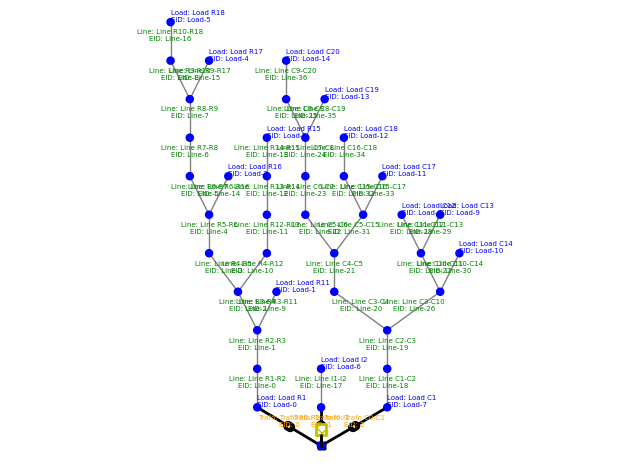

In [11]:
fig, ax = plt.subplots()
plot.simple_plot(net, ax=ax, show_plot=False)

# --- Annotate LOADS ---
for load in loads:
    load_data = net.load.iloc[load.extra_info['index']]
    x, y = net.bus_geodata.loc[load_data['bus'], ['x', 'y']]     
    ax.text(x, y, f'Load: {load_data['name']}\nEID: {load.eid}', fontsize=5, color='blue')

# --- Annotate LINES ---
for line in lines:
    line_data = net.line.iloc[line.extra_info['index']]
    fb, tb = line_data['from_bus'], line_data['to_bus']
    x1, y1 = net.bus_geodata.loc[fb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[tb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = line_data['name']
    ax.text(xm, ym, f'Line: {line_data['name']}\nEID: {line.eid}', fontsize=5, color='green', ha='center')

# --- Annotate TRANSFORMERS ---
for eid, trafo in net.trafo.iterrows():
    hb, lb = trafo.hv_bus, trafo.lv_bus
    x1, y1 = net.bus_geodata.loc[hb, ['x', 'y']]
    x2, y2 = net.bus_geodata.loc[lb, ['x', 'y']]
    xm, ym = (x1 + x2) / 2, (y1 + y2) / 2
    name = trafo['name']
    ax.text(xm, ym, f'Trafo: {name}\nEID: {eid}', fontsize=5, color='orange', ha='center')

# --- Annotate GENERATORS ---
for gen in generators:
    gen_data = net.sgen.iloc[gen.extra_info['index']]
    x, y = net.bus_geodata.loc[gen_data['bus'], ['x', 'y']]    
    ax.text(x + 5, y + 5, f'Gen: {gen_data['name']}\nEID: {gen.eid}', fontsize=5, color='red')

# --- Annotate SHUNTS ---
for eid, shunt in net.shunt.iterrows():
    bus = shunt.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = shunt['name'] 
    ax.text(x - 5, y - 5, f'Shunt: {name}\nEID: {eid}', fontsize=5, color='purple')

# --- Annotate STORAGE ---
for eid, storage in net.storage.iterrows():
    bus = storage.bus
    x, y = net.bus_geodata.loc[bus, ['x', 'y']]
    name = storage['name'] 
    ax.text(x + 5, y - 5, f'Storage: {name}\nEID: {eid}', fontsize=5, color='brown')

plt.tight_layout()
plt.savefig("topology.pdf")
plt.show()


Run the simulation

In [12]:
 # Run simulation
    
world.run(until=END)

2025-05-15 18:23:08.835 | INFO     | mosaik.async_scenario:run:789 - Starting simulation.
100%|██████████| 10800/10800 [00:00<00:00, 23145.63steps/s]
2025-05-15 18:23:09.303 | INFO     | mosaik.async_scenario:run:845 - Simulation finished successfully.


Tensão nas barras

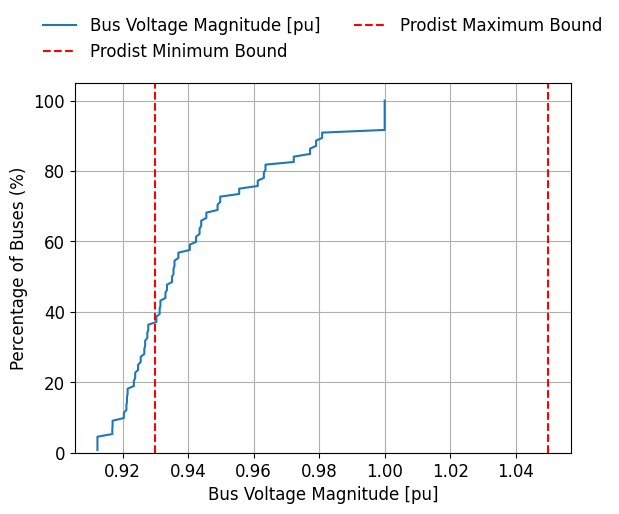

In [13]:
# Função para plotar CDF com sombra
def plot_cdf_with_shadow(data_mean, data_hi, data_lo, label):
    sorted_data_mean = np.sort(data_mean)
    #cdf = 100*np.arange(len(sorted_data_mean)) / float(len(sorted_data_mean))
    cdf = np.arange(1, len(sorted_data_mean) + 1) / len(sorted_data_mean) * 100

    
    sorted_data_hi = np.sort(data_hi)
    sorted_data_lo = np.sort(data_lo)
    
    plt.plot(sorted_data_mean, cdf, label=label)
    plt.fill_betweenx(cdf, sorted_data_lo, sorted_data_hi, alpha=0.2)


# Read the CSV file
df = pd.read_csv('results.csv', parse_dates=['date'], index_col='date')

# Filter columns that match the Bus voltage magnitude pattern
voltage_columns = [col for col in df.columns if re.search(r"Bus-\d+-Vm_[a|b|c]\[pu\]$", col)]
voltage_df = df[voltage_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': voltage_df.mean(),
    'Max': voltage_df.max(),
    'Min': voltage_df.min()
})


# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Voltage Magnitude [pu]')

plt.xlabel('Bus Voltage Magnitude [pu]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Perda de potência ativa nas barras

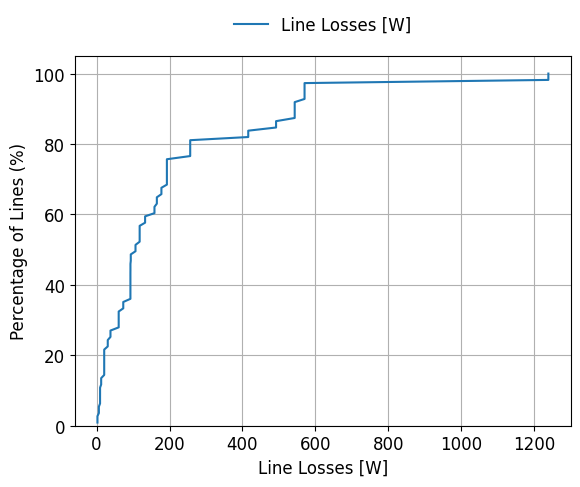

In [14]:

# Filter columns that match the Bus voltage magnitude pattern
loss_columns = [col for col in df.columns if re.search(r"Line-\d+-Pl_[a|b|c]\[MW\]$", col)]
loss_df = df[loss_columns]*1e6

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': loss_df.mean(),
    'Max': loss_df.max(),
    'Min': loss_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Losses [W]')

plt.xlabel('Line Losses [W]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()



Corrente de Neutro

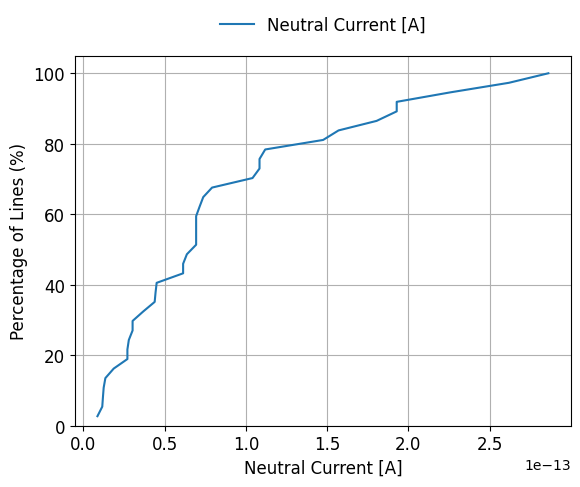

In [15]:
# Filter columns that match the Bus voltage magnitude pattern
neutral_current_columns = [col for col in df.columns if re.search(r"Line-\d+-I_n_from\[kA\]$", col)]
neutral_current_df = df[neutral_current_columns]*1e3

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': neutral_current_df.mean(),
    'Max': neutral_current_df.max(),
    'Min': neutral_current_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Neutral Current [A]')

plt.xlabel('Neutral Current [A]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Line Loading

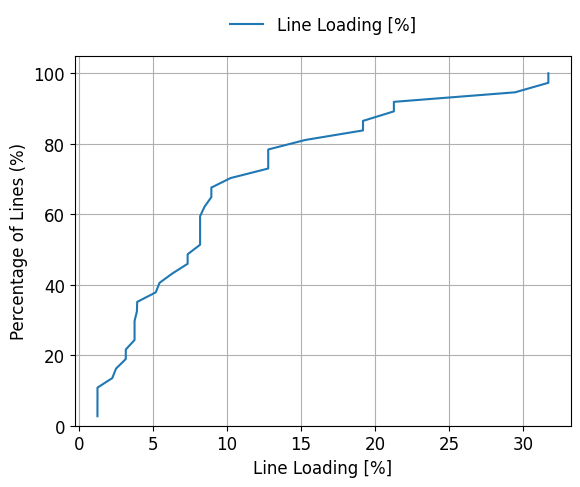

In [16]:
# Filter columns that match the Bus voltage magnitude pattern
line_loading_columns = [col for col in df.columns if re.search(r"Loading\[%\]$", col)]
line_loading_df = df[line_loading_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': line_loading_df.mean(),
    'Max': line_loading_df.max(),
    'Min': line_loading_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Line Loading [%]')

plt.xlabel('Line Loading [%]', fontsize=12)
plt.ylabel('Percentage of Lines (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

Desbalanceamento de Barramentos

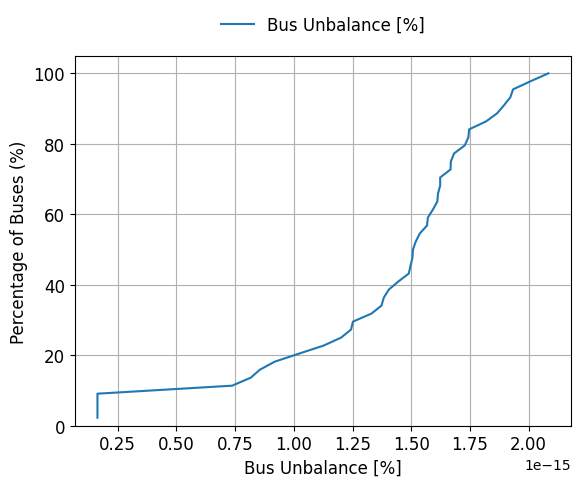

In [18]:

# Filter columns that match the Bus voltage magnitude pattern
unbalance_columns = [col for col in df.columns if re.search(r"Bus-\d+-Unbalance\[%\]$", col)]
unbalance_df = df[unbalance_columns]

# Calculate statistics
stats_df = pd.DataFrame({
    'Average': unbalance_df.mean(),
    'Max': unbalance_df.max(),
    'Min': unbalance_df.min()
})

# Extract each column as vectors
average_vector = stats_df['Average'].values  # as NumPy array
max_vector = stats_df['Max'].values         # as NumPy array
min_vector = stats_df['Min'].values         # as NumPy array

plot_cdf_with_shadow(average_vector, max_vector, min_vector, 'Bus Unbalance [%]')

plt.xlabel('Bus Unbalance [%]', fontsize=12)
plt.ylabel('Percentage of Buses (%)', fontsize=12)
plt.xticks(fontsize=12)                                    # Tamanho dos números no eixo X
plt.yticks(fontsize=12)                                    # Tamanho dos números no eixo Y
#plt.legend(fontsize=12, loc='best', fontsize=12)
#plt.xlim(10, 52)
plt.ylim(0, None)
plt.grid(True)
#plt.axvline(x=0.93, color='red', linestyle='--', linewidth=1.5, label='Prodist Minimum Bound')
#plt.axvline(x=1.05, color='red', linestyle='--', linewidth=1.5, label='Prodist Maximum Bound')
#plt.legend(loc='upper right', bbox_to_anchor=(1.00, 1.22), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.02), fontsize=12, ncol=2, frameon=False)
plt.show()

